In [53]:
import pandas as pd
import numpy as np

df = pd.read_csv("D:\\문서파일들\\2022-1\\국비지원 교육 211213-220519\\final project\\Data\\reviews_imdb\\오징어게임_imdb.csv")

In [54]:
df.head()
len(df)

5172

In [55]:
reviews = df.review.to_list()
sentences = ",".join(reviews)

In [ ]:
sentences

# 필요 함수들

In [ ]:
pip install contextualized_topic_models

In [4]:
import re
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
# from contextualized_topic_models.models.ctm import CombinedTM
# from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation, bert_embeddings_from_list
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from konlpy.tag import Okt
from tqdm import tqdm

In [5]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('V'):
        return 'v'
    elif pos_tag.startswith('N'):
        return 'n'
    elif pos_tag.startswith('J'):
        return 'a'
    elif pos_tag.startswith('R'):
        return 'r'
    else:
        return None

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

In [93]:
class CustomTokenizer:
    def __init__(self, tagger):
        self.tagger = tagger
    def __call__(self, a):
        a = ''.join(a)
        word_tokens = self.tagger(a)
        
        words = []

        for i in word_tokens:
            text = re.sub('[^a-zA-Z0-9\']','',i).strip()
            text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]','', text)
            if(text != ''):
                words.append(text)
        
        tag_words = nltk.pos_tag(words)
        pos_words = [word for word in tag_words if word[1][0] in {'N'}] #'V','N','J','R'

        temp_list = []
        for token, pos_tag in pos_words:
            tag = get_wordnet_pos(pos_tag)
            if tag != None:
                temp_list.append((token, get_wordnet_pos(pos_tag)))
        lemma = WordNetLemmatizer()
        token_final = [lemma.lemmatize(token, pos=tag) for token, tag in temp_list]
        long_words = [i for i in token_final if len(i) > 2]
        results = [w for w in long_words if w not in stop_words]
        return results

<>:12: DeprecationWarning: invalid escape sequence \?
<>:12: DeprecationWarning: invalid escape sequence \?
<>:12: DeprecationWarning: invalid escape sequence \?
<ipython-input-93-fa2cb045d783>:12: DeprecationWarning: invalid escape sequence \?
  text = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`…》]','', text)


# 작업

In [ ]:
ngram_range = (1,2)
stop_words = set(stopwords.words('english'))
stop_words.update(('\r', '\n', '\r\n', '\n\r'))

custom_tokenizer = CustomTokenizer(text_to_word_sequence)
custom_tokenizer(sentences)

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,ngram_range = ngram_range, stop_words=stop_words,
                        max_df=10, min_df=2,max_features=10000).fit(reviews)
candidates = tfidf.get_feature_names()

# LDA

In [94]:
lda_tokens = []
custom_tokenizer = CustomTokenizer(text_to_word_sequence)
for sentences in reviews:
    lda_tokens.append(custom_tokenizer(sentences))
lda_tokens[0]

['character',
 'room',
 'man',
 'hair',
 'board',
 'plane',
 'beginning',
 'expectation']

In [95]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 사전 생성
dictionary = corpora.Dictionary(lda_tokens)

# 빈도수, 비중 필터
dictionary.filter_extremes(no_below=2, no_above=0.5)

# count vectorize
corpus = [dictionary.doc2bow(text) for text in lda_tokens]

2022-04-20 16:37:59,970 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-04-20 16:38:00,044 : INFO : built Dictionary(5523 unique tokens: ['beginning', 'board', 'character', 'expectation', 'hair']...) from 5172 documents (total 56848 corpus positions)
2022-04-20 16:38:00,045 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(5523 unique tokens: ['beginning', 'board', 'character', 'expectation', 'hair']...) from 5172 documents (total 56848 corpus positions)", 'datetime': '2022-04-20T16:38:00.045778', 'gensim': '4.1.2', 'python': '3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}
2022-04-20 16:38:00,054 : INFO : discarding 2871 tokens: [('fluent', 1), ('blessing', 1), ('cheery', 1), ('flak', 1), ('apocalyptic', 1), ('blog', 1), ('denial', 1), ('detector', 1), ('enforcement', 1), ('grinding', 1)]...
2022-04-20 16:38:00,058 : INFO : keeping 2652 tokens which were in no less than 2

In [ ]:
num_topics = 5
chunksize = 2000
passes = 20
iterations = 400
eval_every = 1

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
)

In [99]:
top_topics = model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2022-04-20 16:42:13,481 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-04-20 16:42:13,488 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-04-20 16:42:13,492 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-04-20 16:42:13,494 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-04-20 16:42:13,496 : INFO : CorpusAccumulator accumulated stats from 5000 documents


Average topic coherence: -4.4327.
[([(0.08924175, 'game'),
   (0.02360342, 'people'),
   (0.019195765, 'character'),
   (0.016937379, 'money'),
   (0.013684687, 'life'),
   (0.01256094, 'series'),
   (0.011858495, 'man'),
   (0.011610137, 'player'),
   (0.010875908, 'end'),
   (0.0098921675, 'episode'),
   (0.008943619, 'plot'),
   (0.008873306, 'death'),
   (0.007738446, 'time'),
   (0.0074856626, 'show'),
   (0.007401669, 'way'),
   (0.0071771536, 'world'),
   (0.007062261, 'squid'),
   (0.0063025164, 'story'),
   (0.0060500945, 'season'),
   (0.006005639, 'brother')],
  -1.6929294334420302),
 ([(0.10637078, 'show'),
   (0.035787344, 'character'),
   (0.024710445, 'story'),
   (0.022646077, 'episode'),
   (0.021990197, 'game'),
   (0.01895585, 'time'),
   (0.018561194, 'actor'),
   (0.016230859, 'acting'),
   (0.0151940035, 'vip'),
   (0.014633809, 'thing'),
   (0.013652033, 'season'),
   (0.011905081, 'way'),
   (0.011005229, 'people'),
   (0.010668829, 'plot'),
   (0.0104632545, 'w

In [98]:
# 시각화
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, dictionary, sort_topics=True)
pyLDAvis.display(vis)

# 임베딩

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
# doc_embedding = model.encode([sentence])
doc_embedding = model.encode([sentences])
candidate_embeddings = model.encode(candidates)

In [ ]:
candidate_embeddings.shape, doc_embedding.shape

((61, 768), (1, 768))

# 코사인 유사도 함수

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
top_n = 1000
diversity = 0.7

def mmr(doc_embedding, candidate_embeddings, words, top_n, diversity):
    word_doc_distances = cosine_similarity(candidate_embeddings,doc_embedding)
    word_distances = cosine_similarity(candidate_embeddings) 

    keywords_idx = [np.argmax(word_doc_distances)]
    candidates_idx = [i for i in range(len(candidates)) if i != keywords_idx[0]]
    
    for _ in range(top_n-1):
        try:
        # 후보 키워드들의 문서유사도 값
            candidate_similarities = word_doc_distances[candidates_idx, :]
            # 후보 키워드와 가장 유사한 키워드
            target_similarities = np.max(word_distances[candidates_idx][:,keywords_idx], axis=1) 

            mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1,1)
            mmr_idx = candidates_idx[np.argmax(mmr)]

            keywords_idx.append(mmr_idx)
            candidates_idx.remove(mmr_idx)
        except:
            break

    # 본 단어 임베딩벡터에서 추출키워드에 해당하는 벡터만
    keywords_vector = candidate_embeddings[keywords_idx][:] 
    keywords = [words[idx] for idx in keywords_idx]
    
    return keywords_vector, keywords


In [ ]:
keywords_vector, keywords = mmr(doc_embedding,candidate_embeddings,candidates,top_n=500,diversity=0.6)

In [ ]:
keywords_vector.shape

(61, 768)

In [ ]:
keywords[:10]

['seo favorite',
 'fight scene make',
 'kdrama ive watch',
 'supernatural phenomenon',
 'disappoint drama',
 'father also',
 'power money',
 'prison playbook',
 'korean film making',
 'teach lot']

# KMEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

X = keywords_vector

true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X.T)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = keywords # = candidates
for i in range(true_k):
    print("["),
    for ind in order_centroids[i, :20]:
        print(f'"{terms[ind]}"', end=",")
    print("],\n")

Top terms per cluster:
[
"way","perfect","really","able","good","also","anything","seem","let","find","make","take","first","south","add","soo","adopt","pas","bit","try",],

[
"kill husband","prison daughter","husband","eun soo","mother law","prison","mother daughter","romance","eun","kill","accuse kill","emotional drama","father","daughter adopt","mother","law","daughter","good story","heart","soo",],

[
"really","take","lot","bit","let","seem","also","way","deeply","accuse","first","good","anything","scene","find","make","series","plot","drama","story",],

[
"mother daughter","daughter","mother","mother law","daughter adopt","prison daughter","eun","eun soo","emotional","emotional drama","reporter","romance","story","drama","adopt","good story","character","spoiler","plot twist","mystery",],

[
"prison daughter","reporter","kill husband","mother daughter","daughter adopt","husband","mother law","mother","daughter","prison","viewer","eun soo","friend","father","character","romance","t

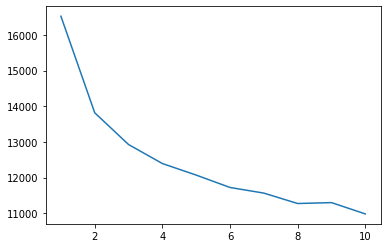

In [ ]:
x = list(range(1,11))
y = []
for i in x:
    model = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=1)
    model.fit(X.T)
    y.append(model.inertia_)

import matplotlib.pyplot as plt

plt.plot(x,y,label='linear')
plt.show();